In [8]:
import os, sys
import numpy as np
import scipy as sp
import scipy.stats
import corner
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch, zuko
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import torch.utils.data as utils
from tqdm import tqdm_notebook as tqdm
from matplotlib import colors as clr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from copy import copy
from matplotlib.lines import Line2D

print(torch.__version__, zuko.__version__)

assert zuko.__version__ == '0.3.2'

2.0.1+cu117 0.3.2


# Loading pre-trained flow

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

loadpath = os.path.split(os.getcwd())[0] + '/pretrained_flows/cnf_dwarf.checkpoint'
checkpoint = torch.load(loadpath, map_location={'cuda:5': device})

flow = zuko.flows.NSF(features=9,  context=6, transforms=10, hidden_features=[256] * 10).to(device)
flow.load_state_dict(checkpoint['model_state_dict'])

print("=> loaded checkpoint (epoch {} - loss {})" .format(checkpoint['epoch'], checkpoint['loss']))

=> loaded checkpoint (epoch 20400 - loss -44.47920018736668)


# Loading in the training grid, selecting dwarfs, and creating scaler functions for observables

In [3]:
data = pd.read_parquet(os.path.split(os.getcwd())[0] + '/grid/p-mode.parquet')

dwarf_cond =  (data.nu_max.values > 300) & (data.eps > 0) &\
(data.dnu01 > -4.5) & (data.dnu01 < 15) & \
(data.dnu02 > 0)  

teff_scaler = StandardScaler()
d01_scaler = StandardScaler()
mms_shell_scaler = MinMaxScaler()
mms_core_scaler = MinMaxScaler()

# Visualization 1: Full-grid emulation

## Here, we want to use input parameters $\mathbf{x}$ across the entire grid to condition the normalizing flow. We then sample from the flow, we should give us the distribution of observables from the grid.

### $\mathbf{x} = [M, \log_{10}Z, Y, \alpha, f_{\mathrm{ov, env}}, f_{\mathrm{ov, core}}]$
### $\mathbf{y} = [T_{\mathrm{eff}}, \Delta\nu, \delta\nu_{01},  \delta\nu_{02},  \delta\nu_{03}, \epsilon, \nu_{\mathrm{max}}, R, \tau]$

We apply transformations to each vector following how they were transformed during training of the flow.

In [4]:
x_mass = data.star_mass.values[dwarf_cond]
x_feh = np.log10(data.Zinit.values[dwarf_cond])
x_init_helium = data.Yinit.values[dwarf_cond]
x_alpha = data.amlt.values[dwarf_cond]
x_ov_env = mms_shell_scaler.fit_transform(data.fov_shell.values[dwarf_cond].reshape(-1,1)).squeeze()
x_ov_core = mms_core_scaler.fit_transform(data.fov_core.values[dwarf_cond].reshape(-1,1)).squeeze()

X = torch.Tensor(np.vstack([  x_mass, x_feh , x_init_helium, 
                            x_alpha, x_ov_env, x_ov_core ]).T).to(device)

# 6D vector X is mass, Z, Y, alpha, f_ov_env, f_ov_env, and f_ov_core

y_teff = data.log_Teff.values[dwarf_cond]
y_teff_scaled = teff_scaler.fit_transform(y_teff.reshape(-1,1)).squeeze()
y_dnu_scaled = np.log10(data.Dnu_freq.values[dwarf_cond])
y_d01 = data.dnu01.values[dwarf_cond]
y_d01_scaled = d01_scaler.fit_transform(y_d01.reshape(-1,1)).squeeze()
y_d02 = data.dnu02.values[dwarf_cond]
y_d02_scaled = np.log10(y_d02)
y_d03 = data.dnu03.values[dwarf_cond]
y_d03_scaled = np.log10(y_d03 + 3)
y_eps = data.eps.values[dwarf_cond]
y_numax_scaled = np.log10(data.nu_max.values[dwarf_cond])
y_radius_scaled = np.log10(data.radius.values[dwarf_cond])
y_age = (data.star_age.values[dwarf_cond])/1e9
y_age_scaled = np.log10((y_age))

Y = torch.Tensor(np.vstack([ y_teff_scaled,
                            y_dnu_scaled, 
                            y_d01_scaled, 
                            y_d02_scaled, 
                            y_d03_scaled, 
                            y_eps, 
                            y_numax_scaled,
                            y_radius_scaled, y_age_scaled]).T).to(device)

# 9D vector is Teff, DeltaNu, d01, d02, d03, epsilon, numax, radius, and age.

train_dataset = utils.TensorDataset(X, Y) # Define a Pytorch Tensor Dataset
train_dataloader = utils.DataLoader(train_dataset, batch_size=1024)

# Here, we sample across the entire distribution.

## In the following, we pass the $\mathbf{x}$ of the whole training grid through the flow.

In [6]:
y_samps = []
y_logprobs = []
y_s = []
x_s = []

for (X_inp, Y_inp) in tqdm(train_dataloader, total=len(train_dataloader)):
    samps,logprobs = flow(X_inp).rsample_and_log_prob() # Sample from the Flow and calculate the point's log-probability
    y_logprobs.append(logprobs.data.cpu().numpy())
    
    y_s.append(Y_inp.data.cpu().numpy())
    x_s.append(X_inp.data.cpu().numpy())
    y_samps.append(samps.data.cpu().numpy())
    
y_s = np.concatenate(y_s)
y_samps = np.concatenate(y_samps)
y_logprobs = np.concatenate(y_logprobs)

<ipython-input-6-4d130736eae4>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (X_inp, Y_inp) in tqdm(train_dataloader, total=len(train_dataloader)):


  0%|          | 0/434 [00:00<?, ?it/s]

## Reversing transformations to each component in $\mathbf{x}$ and $\mathbf{y}$

In [9]:
cond = y_logprobs > np.percentile(y_logprobs, 5)

_pred = copy(y_samps[cond]) # Emulated grid
_output = copy(y_s) # True training grid

transform_indices = [1, 3, 4, 6, 7]
for idx in transform_indices:
    if idx == 4:
        _output[:, idx] = 10**_output[:, idx] - 3
        _pred[:, idx] = 10**_pred[:, idx] - 3
    else:
        _pred[:, idx] = 10**_pred[:, idx]
        _output[:, idx] = 10**_output[:, idx]
        
_pred[:, 2] = d01_scaler.inverse_transform(_pred[:, 2].reshape(-1, 1)).squeeze()
_output[:, 2] = d01_scaler.inverse_transform(_output[:, 2].reshape(-1, 1)).squeeze()

_pred[:, 0] = teff_scaler.inverse_transform(_pred[:, 0].reshape(-1,1)).squeeze()
_output[:, 0] = teff_scaler.inverse_transform(_output[:, 0].reshape(-1,1)).squeeze()


## This yields Figure 2(a) from the paper!

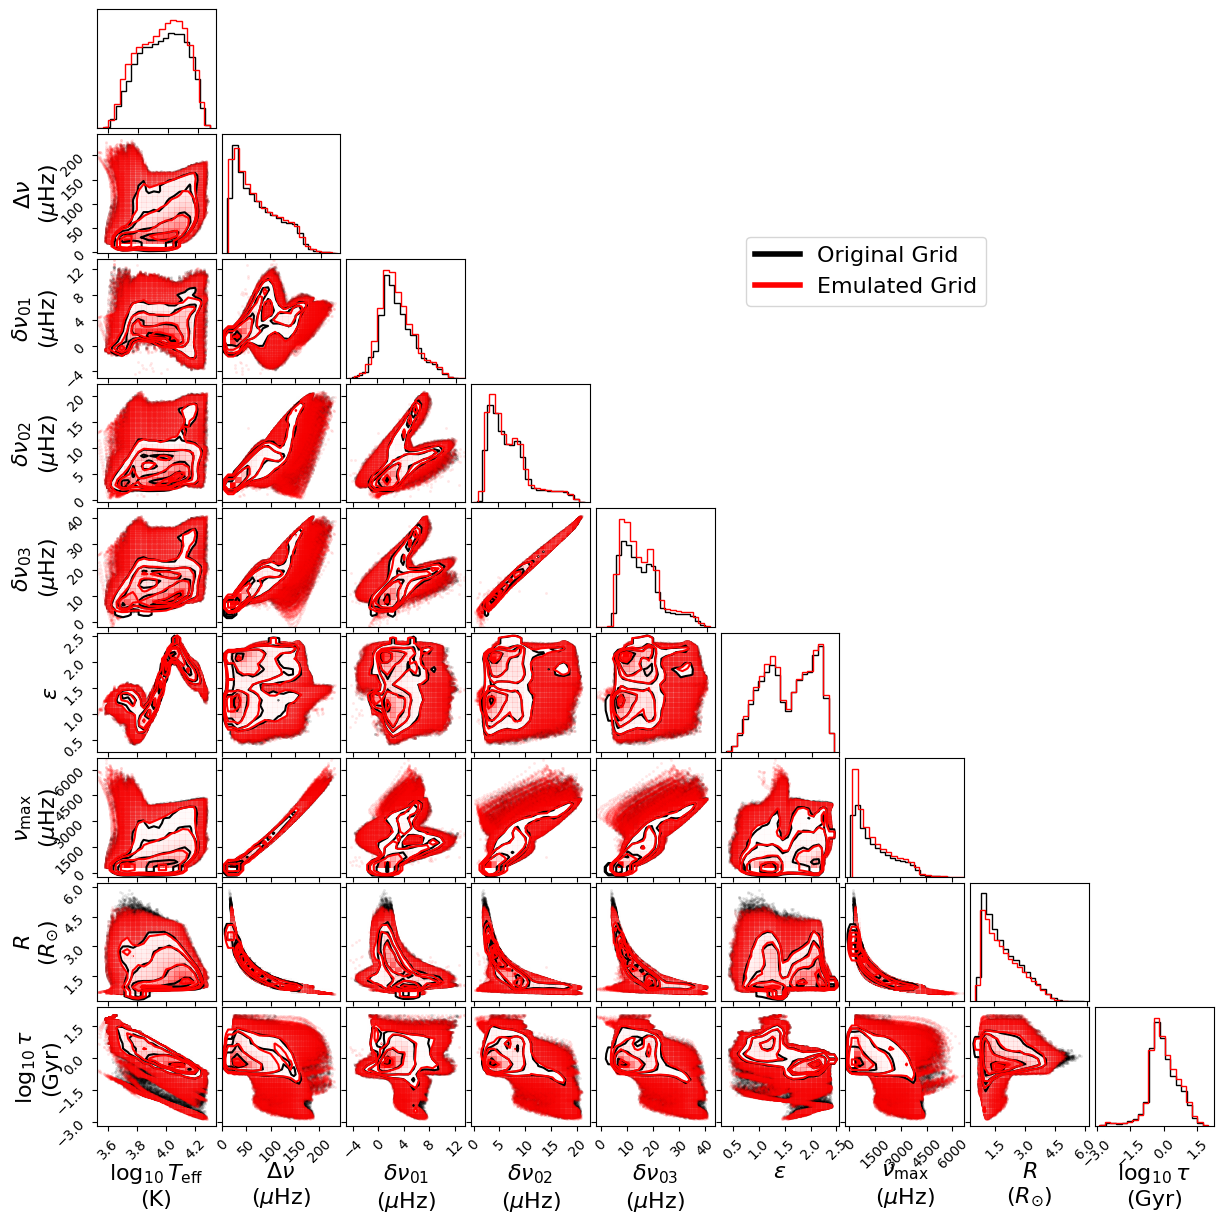

In [10]:
ndim = 9

fig = plt.figure(figsize=(12,12))
fs = 16
labels = ['$\\log_{10}T_{\\mathrm{eff}}$\n(K)',
                  '$\\Delta\\nu$\n($\\mu$Hz)',
                  '$\\delta\\nu_{01}$\n($\\mu$Hz)',
                  '$\\delta\\nu_{02}$\n($\\mu$Hz)',
                  '$\\delta\\nu_{03}$\n($\\mu$Hz)',
                  '$\\epsilon$',
                   '$\\nu_{\\mathrm{max}}$\n($\\mu$Hz)','$R$\n($R_{\\odot}$)',
                  '$\\log_{10}\\tau$\n(Gyr)']


corner.corner(_pred, labels=labels,label_kwargs={"fontsize": fs}, fig=fig)
corner.corner(_output, fig=fig, color='red')

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=fs-6) 
    
legend_elements = [Line2D([0], [0], color='k', lw=4, label='Original Grid'),
                   Line2D([0], [0], color='red', lw=4, label='Emulated Grid')]


fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.8, 0.8), frameon=True, prop={'size': fs})

plt.show()

# Visualization 2: Evolutionary Tracks

### Let's first define a helper function to sample points given $\mathbf{x}$

In [12]:
def infer_samples(flow, cvar, percentile=None):
    """
    Infer samples from a given flow model conditioned on a specific variable.

    This function infers samples from a specified flow model based on a conditioning variable. It can also filter 
    these samples based on a percentile of their log probabilities, effectively trimming the less probable samples.

    Parameters
    ----------
    flow : torch.nn.Module
        The Zuko flow model from which samples are to be drawn.
    cvar : array_like
        The conditioning variable on which the flow model samples are conditioned. This should be compatible with the input
        expected by the `flow` model.
    percentile : float, optional
        The percentile of log probabilities below which samples are discarded. If `None` (the default), all samples
        are returned.

    Returns
    -------
    numpy.ndarray
        The inferred samples. If `percentile` is not None, only samples with log probabilities above the specified
        percentile are returned.
    numpy.ndarray, optional
        The indices of the samples returned. This is only returned if `percentile` is not None.

    """
    with torch.no_grad():
        # Generate samples and log probabilities from the flow model
        ss2, ss_logprobs = flow(torch.Tensor(cvar).to(device)).rsample_and_log_prob((1,))
        ss_logprobs = ss_logprobs.data.cpu().numpy().squeeze()
        ss2 = ss2.data.cpu().numpy().squeeze()

    # If percentile is specified, filter samples based on their log probabilities
    if percentile is not None:
        condition = ss_logprobs > np.percentile(ss_logprobs, percentile)
        return ss2[condition], np.arange(len(ss2))[condition]
    else:
        return ss2

## Here, we draw 100000 samples and emulate $p(\mathbf{y}|\mathbf{x})$, where $\mathbf{x} = [\hat{M}, -1.9, 0.277, 1.9, 0.5, 0.5]$. Note that $\hat{M}\in [0.7, 1.0, 1.5, 2, 2.5]\,M_{\odot}$, while $f_{\mathrm{ov,core}}$ and $f_{\mathrm{ov,shell}}$ are scaled versions of their original values.

In [15]:
num_marginals = 100000 # Set number of samples here
num_samples = 1

fehvar = -1.9  
massvar = [0.7, 1.0 , 1.5, 2., 2.5]
heliumvar = 0.277
alfvar = 1.9
ovshellvar = 0.5
ovcorevar = 0.5

cv = np.ones((num_marginals, 6)) 

for i in range(len(massvar)):
    cv[ int(i/len(massvar)*num_marginals) : int((i+1)/len(massvar)*num_marginals), 0] = massvar[i]
cv[:,1] = fehvar
cv[:,2] = heliumvar
cv[:,3] = alfvar
cv[:,4] = ovshellvar
cv[:,5] = ovcorevar

cvar = torch.Tensor(cv).to(device)
emulated_samples, keep_indices = infer_samples(flow, cvar, percentile = 5) 

# Note that `emulated_samples` has the same dimensions and components as $\mathbf{y}$ from the training grid.
## The following plotting code yields Figure 3 in the paper

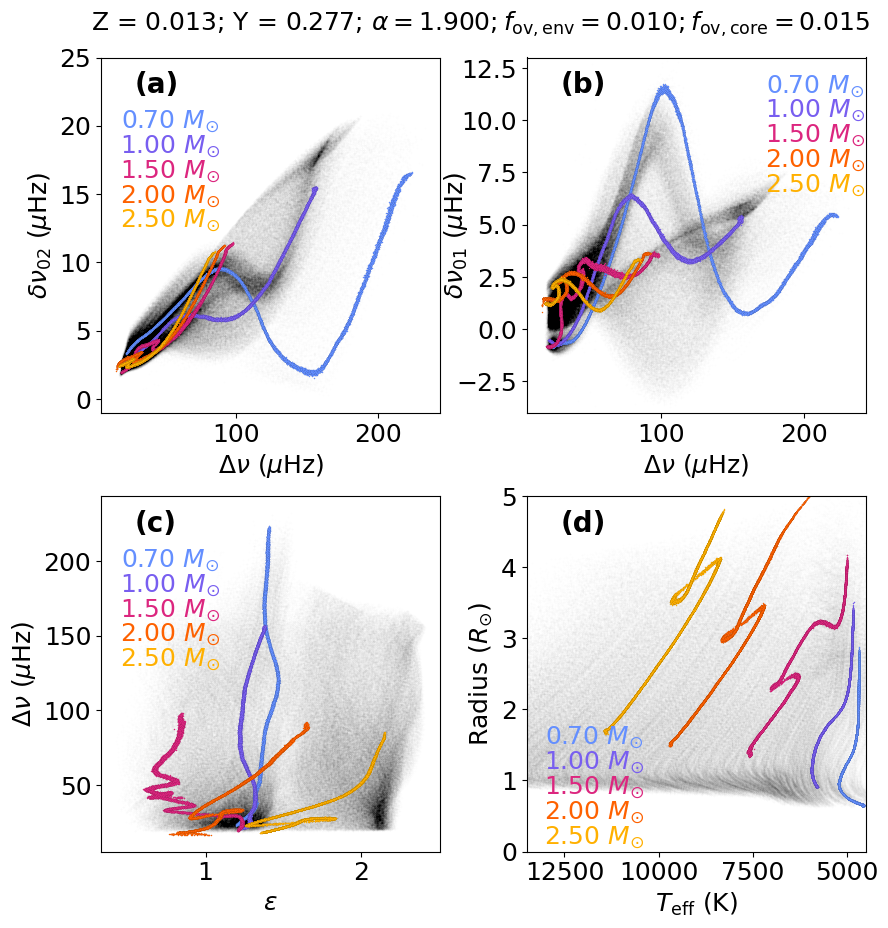

In [19]:
fig = plt.figure(figsize=(9,9))
ax1, ax2 = fig.add_subplot(221), fig.add_subplot(222)
ax3, ax4 = fig.add_subplot(223), fig.add_subplot(224)
colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
axlabel = ['(a)', '(b)', '(c)', '(d)']

fs = 18
alpha=0.005
lw=0.015

ax1.scatter(10**y_dnu_scaled, 10**y_d02_scaled, s=1, c='k', alpha=alpha)
ax2.scatter(10**y_dnu_scaled, y_d01, s=1, c='k', alpha=alpha)
ax3.scatter(y_eps, 10**y_dnu_scaled,s=1, c='k', alpha=alpha)
ax4.scatter(10**y_teff, 10**y_radius_scaled,s=1, c='k', alpha=alpha)
ax1.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
ax1.set_ylabel('$\\delta\\nu_{02}$ ($\\mu$Hz)', fontsize=fs)
ax2.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
ax2.set_ylabel('$\\delta\\nu_{01}$ ($\\mu$Hz)', fontsize=fs, labelpad=-10)
ax3.set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
ax3.set_xlabel('$\\epsilon$', fontsize=fs)
ax4.invert_xaxis()
ax4.set_ylabel('Radius $(R_{\\odot})$', fontsize=fs)
ax4.set_xlabel('$T_{\\mathrm{eff}}$ (K)', fontsize=fs)
ax1.set_ylim(-1, 25)
ax2.set_ylim(-4, 13)
ax4.set_ylim(0., 5)
ax4.set_xlim(13500, 4500)

for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.text(s= axlabel[i], fontsize=fs+2, transform=ax.transAxes, color='k',
            fontweight='bold', x=0.1, y=0.9)
    
for i,m in enumerate(massvar):
    select_indices = cv[keep_indices, 0] == m
    ax1.scatter(10**emulated_samples[select_indices,1], 10**emulated_samples[select_indices,3], s=1, c=colors[i], edgecolor='k', lw=lw)
    ax2.scatter(10**emulated_samples[select_indices,1],
                d01_scaler.inverse_transform(emulated_samples[select_indices,2].reshape(-1,1)).squeeze(), s=1, 
                c=colors[i], edgecolor='k', lw=lw)
    ax3.scatter(emulated_samples[select_indices,5], 10**emulated_samples[select_indices,1], s=1, c=colors[i], edgecolor='k', lw=lw)
    ax4.scatter( 10**teff_scaler.inverse_transform(emulated_samples[select_indices,0].reshape(-1,1)).squeeze(), 
                10**emulated_samples[select_indices,-2], s=1, c=colors[i], edgecolor='k', lw=lw)

    

plt.tight_layout(w_pad=2, h_pad=0.5)
fig.text(s='Z = %.3f; Y = %.3f; $\\alpha = %.3f; f_{\mathrm{ov, env}} = %.3f; f_{\mathrm{ov, core}} = %.3f$'\
         %(10**fehvar, heliumvar, alfvar,
           mms_shell_scaler.inverse_transform(np.array(ovshellvar).reshape(-1,1)).squeeze(),
          mms_core_scaler.inverse_transform(np.array(ovcorevar).reshape(-1,1)).squeeze()),
        x=0.54, y=1.0025, ha='center', fontsize=fs, color='k')

for i in range(len(massvar)):
    ax1.text(s='%.2f $M_{\\odot}$' %(massvar[i]),
        x=0.205, y=0.8 - i*0.07, ha='center', fontsize=fs, color=colors[i], transform=ax1.transAxes)
    ax2.text(s='%.2f $M_{\\odot}$' %(massvar[i]),
        x=0.85, y=0.9 - i*0.07, ha='center', fontsize=fs, color=colors[i], transform=ax2.transAxes)   
    ax3.text(s='%.2f $M_{\\odot}$' %(massvar[i]),
        x=0.205, y=0.8 - i*0.07, ha='center', fontsize=fs, color=colors[i], transform=ax3.transAxes) 
    ax4.text(s='%.2f $M_{\\odot}$' %(massvar[i]),
        x=0.2, y=0.3 - i*0.07, ha='center', fontsize=fs, color=colors[i], transform=ax4.transAxes) 



plt.show()


# Visualization 3: A Continuum of Evolutionary Tracks by Marginalizing Input Parameters

## This is very similar to Visualization 2, except that we allow an input parameter to freely range between its minimum and maximum values from the training grid.

### First we define helper functions for plotting

In [25]:
def univariate_d01d02eps_row(d01, d02, eps, dnu, teff, radius,
                        conditional_name, conditional_unit, conditional_val,
                        colors, hr_hot_lim = 20047.182678009627,
                             show=True, axlist=None, lastrow=True, firstrow=True, fs=12):
    
    if axlist is None:
        fig = plt.figure(figsize=(15,5))
        ax1, ax2 = fig.add_subplot(141), fig.add_subplot(142)
        ax3, ax4 = fig.add_subplot(143), fig.add_subplot(144)
        
    else:
        assert len(axlist) == 4
        ax1, ax2, ax3, ax4 = axlist[0], axlist[1], axlist[2], axlist[3]        

    downsamp = 1

    ax1.scatter(10**y_dnu_scaled[::downsamp], 10**y_d02_scaled[::downsamp], s=1, c='k', alpha=0.025)
    ax1.scatter(dnu, d02, s=2, c=colors)
    ax1.text(x=0.3, y=0.85, s='%s = %s %s' %(conditional_name, conditional_val, conditional_unit),
             transform = ax1.transAxes,
            fontsize=fs-2, ha='center')
    ax1.set_xlim((7.2167596864755765, 223.20284723531213))
    ax1.set_ylim((-0.7243560209115851, 21.946998024114134))
    
    
    ax2.scatter(10**y_dnu_scaled[::downsamp], y_d01[::downsamp], s=1, c='k', alpha=0.025)
    ax2.scatter(dnu, d01,
                s=2, c=colors)

    ax2.set_xlim((-11.62380321284918, 244.10001689718473))
    ax2.set_ylim((-5.309158061681022, 14.312067750913858))
    
    ax3.scatter(y_eps[::downsamp], 10**y_dnu_scaled[::downsamp],s=1, c='k', alpha=0.025)
    ax3.scatter(eps, dnu, s=2, c=colors)

    ax3.set_xlim((0.3271256056391496, 2.508549924824976))
    ax3.set_ylim((7.2167596864755765, 243.20284723531213))    
    
    ax4.scatter(10**y_teff[::downsamp], 10**y_radius_scaled[::downsamp],s=1, c='k', alpha=0.025)
    ax4.scatter( teff,
                radius, s=2, c=colors)
    ax4.invert_xaxis()
#     ax4.set_yscale('log')
#     ax4.set_xscale('log')
    ax4.set_xlim((hr_hot_lim, 3548.3011150806565))
    ax4.set_ylim((0.5518059994683946, 5.042655107511573))    
    
    [ax.tick_params(axis='both', which='major', labelsize=fs) for ax in [ax1,ax2,ax3,ax4]]
    
    if lastrow:
        ax1.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
        ax2.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
        ax3.set_xlabel('$\\epsilon$', fontsize=fs)
        ax4.set_xlabel('$T_{\\mathrm{eff}}$ (K)', fontsize=fs) 
        
    else:
        [ax.set_xticklabels([]) for ax in [ax1,ax2,ax3, ax4]]
        
    if firstrow:
        ax1.set_title('C-D diagram', fontsize=fs)
        ax2.set_title('$\\delta\\nu_{01}-\\Delta\\nu$ diagram', fontsize=fs)
        ax3.set_title('$\\Delta\\nu-\\epsilon$ diagram', fontsize=fs)
        ax4.set_title('H-R diagram', fontsize=fs)

        # Remove the x-axis tick labels
#         ax4.xaxis.set_major_formatter(ticker.NullFormatter())
#         ax4.xaxis.set_major_locator(ticker.NullLocator())
        
    ax1.set_ylabel('$\\delta\\nu_{02}$ ($\\mu$Hz)', fontsize=fs)
    ax2.set_ylabel('$\\delta\\nu_{01}$ ($\\mu$Hz)', fontsize=fs, labelpad=-1.75)
    ax3.set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
    ax4.set_ylabel('Radius $(R_{\\odot})$', fontsize=fs)
    plt.tight_layout(w_pad=1)

    if show:
        plt.show()
        
def mass_multirow_d01d02eps_row(conditional_vals,
                           varyparam, limdict,
                           feh = -1.9,
                           Y = 0.277,
                           alf = 1.9,
                           ovshell = 0.5,
                           ovcore = 0.5,
                           fs = 14,
                           num_marginals = 100000,
                           **kwargs):
    
    if varyparam not in ['Z', 'Y', 'alf', 'ovshell', 'ovcore']:
        raise ValueError("varyparam must be one of ['Z', 'Y', 'alf', 'ovshell', 'ovcore']")
    
    num_samples = 1
    colormap = plt.cm.Spectral
    fig = plt.figure(figsize=(15, len(conditional_vals*3)))
    tot_figs = int(len(conditional_vals) * 4)
    lastrow=False
    firstrow=True
    
    params = dict(Z = feh,
                 Y = Y,
                 alf = alf,
                 ovshell = ovshell,
                 ovcore = ovcore)
    
    labeldict = dict(Z = '$\\log_{10}Z$',
                 Y = '$Y$',
                 alf = '$\\alpha$',
                 ovshell = 'ov$_{\\mathrm{shell}}$',
                 ovcore = 'ov$_{\\mathrm{core}}$')
    
    params[varyparam] = np.random.uniform(low= limdict[varyparam][0],
                                          high = limdict[varyparam][1],
                                          size=num_marginals)
    
    for i, m in enumerate(conditional_vals):
        axlist = [fig.add_subplot(len(conditional_vals), 4, i*4 + ix + 1) for ix in range(4) ]                
        fehvar = params['Z'] # -1.9 log10(Z) is roughly solar metallicity
        massvar = m
        heliumvar = params['Y']
        alfvar = params['alf']
        ovshellvar = params['ovshell']
        ovcorevar = params['ovcore']  

        cv = np.ones((num_marginals, 6)) # mass ,log10(Z), Y, alpha
        cv[:,0] = massvar
        cv[:,1] = fehvar
        cv[:,2] = heliumvar
        cv[:,3] = alfvar
        cv[:,4] = ovshellvar
        cv[:,5] = ovcorevar

        cvar = torch.Tensor(cv).to(device)
        ss, keep_indices = infer_samples(flow, cvar, percentile = 5) 
        norm = clr.Normalize(vmin=params[varyparam].min(), vmax=params[varyparam].max())
        scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
        colors = scalar_mappable.to_rgba(params[varyparam])
        
        if i > 0:
            firstrow=False
        
        if i == len(conditional_vals) - 1:
            lastrow=True
            cax = fig.add_axes([0.05, 1.01, 0.94, 0.0405/len(conditional_vals)])
            cb1 = fig.colorbar(scalar_mappable, cax=cax, orientation='horizontal')
            cb1.set_label(label=labeldict[varyparam], fontsize=fs)
            cb1.ax.tick_params(labelsize=fs) 
            cax.xaxis.set_label_position('top')
            cax.xaxis.set_ticks_position('top')
            
        univariate_d01d02eps_row(**kwargs, conditional_val=m,
                        colors=colors[keep_indices], 
                         d01 = d01_scaler.inverse_transform(ss[:,2].reshape(-1,1)).squeeze(),
                          d02=10**ss[:,3],
                          eps = ss[:,5],
                          dnu=10**ss[:,1],
                          teff = 10**teff_scaler.inverse_transform(ss[:,0].reshape(-1,1)).squeeze(),
                          radius = 10**ss[:,-2],
                                 show=lastrow, axlist=axlist,
                                lastrow=lastrow, firstrow=firstrow, fs=fs)
        
        plt.tight_layout(h_pad=0)

In [29]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def univariate_d01d02eps_row(d01, d02, eps, dnu, teff, radius,
                             conditional_name, conditional_unit, conditional_val,
                             colors, hr_hot_lim=20047.182678009627,
                             show=True, axlist=None, lastrow=True, firstrow=True, fs=12):
    """
    Plot univariate distributions of d01, d02, epsilon, dnu, teff, and radius, along with conditionals.
    
    Parameters:
    - d01: Array of delta nu 01 values.
    - d02: Array of delta nu 02 values.
    - eps: Array of epsilon values.
    - dnu: Array of delta nu values.
    - teff: Array of effective temperature values.
    - radius: Array of radius values.
    - conditional_name: Name of the conditional variable being plotted.
    - conditional_unit: Unit of the conditional variable.
    - conditional_val: Value of the conditional variable.
    - colors: Array of colors for the scatter plot points.
    - hr_hot_lim: HR diagram hot limit. Default is 20047.182678009627.
    - show: Boolean indicating whether to show the plot. Default is True.
    - axlist: List of axis objects if plotting on an existing figure. Default is None.
    - lastrow: Boolean indicating if this is the last row (for label positioning). Default is True.
    - firstrow: Boolean indicating if this is the first row (for title positioning). Default is True.
    - fs: Font size for the plot labels and titles. Default is 12.
    """
    if axlist is None:
        fig = plt.figure(figsize=(15, 5))
        ax1, ax2, ax3, ax4 = [fig.add_subplot(1, 4, i + 1) for i in range(4)]
    else:
        assert len(axlist) == 4, "axlist must contain exactly 4 axes."
        ax1, ax2, ax3, ax4 = axlist

    # Downsampling for performance (adjust as needed)
    downsamp = 1

    # Scatter plots
    ax1.scatter(dnu[::downsamp], d02[::downsamp], s=2, c=colors)
    ax2.scatter(dnu[::downsamp], d01[::downsamp], s=2, c=colors)
    ax3.scatter(eps[::downsamp], dnu[::downsamp], s=2, c=colors)
    ax4.scatter(teff[::downsamp], radius[::downsamp], s=2, c=colors)
    ax4.invert_xaxis()

    # Axis limits
    ax1.set_xlim((7.2167596864755765, 223.20284723531213))
    ax1.set_ylim((-0.7243560209115851, 21.946998024114134))
    ax2.set_xlim((-11.62380321284918, 244.10001689718473))
    ax2.set_ylim((-5.309158061681022, 14.312067750913858))
    ax3.set_xlim((0.3271256056391496, 2.508549924824976))
    ax3.set_ylim((7.2167596864755765, 243.20284723531213))
    ax4.set_xlim((hr_hot_lim, 3548.3011150806565))
    ax4.set_ylim((0.5518059994683946, 5.042655107511573))

    # Setting labels and titles
    if lastrow:
        ax1.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
        ax2.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
        ax3.set_xlabel('$\\epsilon$', fontsize=fs)
        ax4.set_xlabel('$T_{\\mathrm{eff}}$ (K)', fontsize=fs)

    if firstrow:
        ax1.set_title('C-D diagram', fontsize=fs)
        ax2.set_title('$\\delta\\nu_{01}-\\Delta\\nu$ diagram', fontsize=fs)
        ax3.set_title('$\\Delta\\nu-\\epsilon$ diagram', fontsize=fs)
        ax4.set_title('H-R diagram', fontsize=fs)

    ax1.set_ylabel('$\\delta\\nu_{02}$ ($\\mu$Hz)', fontsize=fs)
    ax2.set_ylabel('$\\delta\\nu_{01}$ ($\\mu$Hz)', fontsize=fs, labelpad=-1.75)
    ax3.set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
    ax4.set_ylabel('Radius $(R_{\\odot})$', fontsize=fs)

    # Conditional text
    ax1.text(0.3, 0.85, f'{conditional_name} = {conditional_val} {conditional_unit}', transform=ax1.transAxes, fontsize=fs-2, ha='center')

    plt.tight_layout(w_pad=1)
    if show:
        plt.show()

def mass_multirow_d01d02eps_row(conditional_vals, varyparam, limdict, feh=-1.9, Y=0.277, alf=1.9,
                                ovshell=0.5, ovcore=0.5, fs=14, num_marginals=100000, **kwargs):
    """
    Generates multi-row plots for stellar oscillation and physical parameters for stars of varying masses,
    highlighting the effects of changing a specific stellar parameter (varyparam).

    Parameters:
    - conditional_vals: List of values (masses) for which the plots are generated. Each value corresponds to a new row of plots.
    - varyparam: The stellar parameter that varies across plots. Must be one of ['Z', 'Y', 'alf', 'ovshell', 'ovcore'].
    - limdict: A dictionary specifying the lower and upper limits for the varied parameter's random uniform distribution.
    - feh: Metallicity (default: -1.9).
    - Y: Helium content (default: 0.277).
    - alf: Mixing length parameter (default: 1.9).
    - ovshell: Overshooting parameter for the shell (default: 0.5).
    - ovcore: Overshooting parameter for the core (default: 0.5).
    - fs: Font size for plot texts (default: 14).
    - num_marginals: Number of marginal samples for the varied parameter (default: 100000).
    - **kwargs: Additional keyword arguments passed to the plotting function.

    Raises:
    - ValueError: If varyparam is not among the expected parameters.
    """
    if varyparam not in ['Z', 'Y', 'alf', 'ovshell', 'ovcore']:
        raise ValueError("varyparam must be one of ['Z', 'Y', 'alf', 'ovshell', 'ovcore']")

    # Initialize figure
    fig = plt.figure(figsize=(15, len(conditional_vals) * 3))
    colormap = plt.cm.Spectral

    # Define parameter and label dictionaries
    params = {'Z': feh, 'Y': Y, 'alf': alf, 'ovshell': ovshell, 'ovcore': ovcore}
    labeldict = {'Z': '$\\log_{10}Z$', 'Y': '$Y$', 'alf': '$\\alpha$', 'ovshell': 'ov$_{\\mathrm{shell}}$', 'ovcore': 'ov$_{\\mathrm{core}}$'}

    # Update the varied parameter with random values within specified limits
    params[varyparam] = np.random.uniform(low=limdict[varyparam][0], high=limdict[varyparam][1], size=num_marginals)

    # Loop over conditional values (masses)
    for i, mass in enumerate(conditional_vals):
        axlist = [fig.add_subplot(len(conditional_vals), 4, i * 4 + ix + 1) for ix in range(4)]

        # Prepare data for plotting
        cv = np.ones((num_marginals, 6))  # Shape for mass, feh, Y, alf, ovshell, ovcore
        cv[:, 0] = mass
        cv[:, 1:] = np.array([params[k] for k in ['Z', 'Y', 'alf', 'ovshell', 'ovcore']]).T

        # Generate colors based on the varied parameter
        norm = plt.Normalize(vmin=params[varyparam].min(), vmax=params[varyparam].max())
        scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
        colors = scalar_mappable.to_rgba(params[varyparam])

        # Call the plotting function for each row
        univariate_d01d02eps_row(colors=colors, axlist=axlist, firstrow=(i == 0), lastrow=(i == len(conditional_vals) - 1), fs=fs, **kwargs)

        # Add colorbar in the last row
        if i == len(conditional_vals) - 1:
            cax = fig.add_axes([0.05, 1.01, 0.94, 0.0405 / len(conditional_vals)])
            cb1 = fig.colorbar(scalar_mappable, cax=cax, orientation='horizontal')
            cb1.set_label(label=labeldict[varyparam], fontsize=fs)
            cb1.ax.tick_params(labelsize=fs)
            cax.xaxis.set_label_position('top')
            cax.xaxis.set_ticks_position('top')

    plt.tight_layout(h_pad=0)

In [30]:
limdict = dict(Z = (min(x_feh), max(x_feh)),
              Y = (min(x_init_helium), max(x_init_helium)),
              alf = (min(x_alpha), max(x_alpha)),
              ovshell = (min(x_ov_env), max(x_ov_env)),
              ovcore = (min(x_ov_core), max(x_ov_core)))
mass_multirow_d01d02eps_row(conditional_vals=[0.8, 1.2, 1.5, 2.],conditional_name = 'Mass',
                       varyparam='Z', limdict=limdict,
                          conditional_unit = '$M_{\\odot}$', fs=18,
                                                      num_marginals = 50000)

plt.tight_layout(h_pad=0)


plt.show()
plt.close()

<ipython-input-29-deb50bc79510>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cv[:, 1:] = np.array([params[k] for k in ['Z', 'Y', 'alf', 'ovshell', 'ovcore']]).T


ValueError: setting an array element with a sequence.